# <b>Classification of Disaster using Tweets

> Natural Language Processing with Disaster Tweets
>    
> Predict which Tweets are about real disasters and which ones are not
>
> Kaggle Dataset [NLP for Disaster in Twitter](https://www.kaggle.com/c/nlp-getting-started)    

### Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation

from src import Cleaning, Visualization

### Data Loading

In [19]:
twitter_df = pd.read_csv('../datasets/nlp-getting-started/train.csv')

In [20]:
twitter_df.sample(5)

,id,keyword,location,text,target
6595,9446,terrorism,everywhere,News786-UK Islamist Cleric Anjem Choudary Char...,1
2604,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
777,1124,blew%20up,"Ottawa, Canada",Zayn just blew up twitter.,0
7105,10179,violent%20storm,Worldwide,Violent Forces Radio: Now Playing Acid Storm -...,1
3079,4416,electrocute,NaN,@danisnotonfire don't let Phil help out he'll ...,0


### Data Processing

In [21]:
twitter_df.shape

(7613, 5)

In [22]:
twitter_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [23]:
'''
    Remove location column and empty keywords rows
'''
twitter_df = twitter_df[['keyword', 'text', 'target']] 
twitter_df.dropna(axis=0, how='any', inplace=True)

In [24]:
twitter_df.sample(10)

,keyword,text,target
6486,sunk,FOOTBALL IS BACK THIS WEEKEND ITS JUST SUNK IN...,0
6288,storm,Happy birthday @lesley_mariiee ?? I miss you s...,0
5495,quarantine,Reddit Will Now Quarantine Offensive Content h...,0
3199,emergency%20plan,City of Calgary activates municipal emergency ...,1
2671,detonate,Detonate (feat. M?.?O?.?P?.?)\nfrom Grandeur b...,0
2385,derail,WSJThinkTank: Ahead of tonight's #GOPDebate Co...,0
3214,emergency%20services,#veterans VET Act would ensure every military ...,0
1604,collapse,Economic Collapse Investing: Specific actions ...,1
625,bioterrorism,CDC has a pretty cool list of all bioterrorism...,1
1246,buildings%20on%20fire,A change in the State fire code prohibits gril...,0


In [25]:
'''
    Clean text from text and keyword columns
'''
clean_text = Cleaning.DataCleaning()
twitter_df.loc[:, 'clean_keyword'] = twitter_df['keyword'].apply(lambda x: " ".join(clean_text(x)))
twitter_df.loc[:, 'clean_text'] = twitter_df['text'].apply(lambda x: " ".join(clean_text(x)))

In [38]:
'''
    Inspect empty columns after cleaning
'''
twitter_df = twitter_df[~twitter_df['clean_text'].isna()]
twitter_df = twitter_df[twitter_df['clean_text'] != '']

twitter_df = twitter_df[~twitter_df['clean_keyword'].isna()]
twitter_df = twitter_df[twitter_df['clean_keyword'] != '']

In [39]:
'''
   Counting words
'''
twitter_df.loc[:, 'word_count'] = twitter_df['clean_text'].apply(lambda x: len(x.split()))

In [43]:
twitter_df[['clean_keyword', 'clean_text', 'word_count']].sample(10)

,clean_keyword,clean_text,word_count
356,army,build army dog leader lion dog fight like lion,9
4278,heat,yay good cooler weather pdx abq nm feeling hea...,14
358,army,one direction pick http fan army directioners ...,8
2109,death,ted cruz bash obama comparison gop iranian sho...,10
1101,bombed,majority killed civilian ground jet first bomb...,12
73,accident,bigrigradio live accident awareness,4
1558,chemical,emergency responder prepare chemical disaster ...,8
873,blood,wind take gypsy blood time http,6
6310,stretcher,min speaker http,3
2006,damage,np metallica damage inc,4


In [45]:
twitter_df[['clean_keyword', 'clean_text', 'word_count']].sort_values(by='word_count', ascending=False).head(10)

,clean_keyword,clean_text,word_count
1942,curfew,rite man tlk widout nuh curfew long side aka c...,23
1540,chemical,bomb crash loot riot emergency pipe bomb nucle...,21
1909,crushed,disillusioned lead character check happy go lu...,21
5980,screaming,like little boy better sit as stop screaming m...,20
1917,curfew,michelleellle shut freshman past ur curfew u n...,19
5434,police,police union retard justice amp drain gov cop ...,19
614,bioterrorism,cagov amp colluded take wht f usagov auth host...,19
5722,rescuer,last second ebay bid rt http shaolin rescuer d...,19
1634,collapsed,great british lt b gt bake lt gt back dorret l...,19
4009,flood,etp bengal flood cm mamata banerjee blame dvc ...,19


### Data Visualization

In [53]:
data_viz = Visualization.Visualization(twitter_df, 'clean_text')
frequency = data_viz.words_frequency()

In [54]:
frequency.head(10)

,words,freq,norm
51,http,1399,0.022570
187,amp,339,0.005469
153,like,315,0.005082
194,fire,291,0.004695
96,get,231,0.003727
599,via,210,0.003388
316,u,165,0.002662
446,people,164,0.002646
460,one,163,0.002630
30,new,144,0.002323


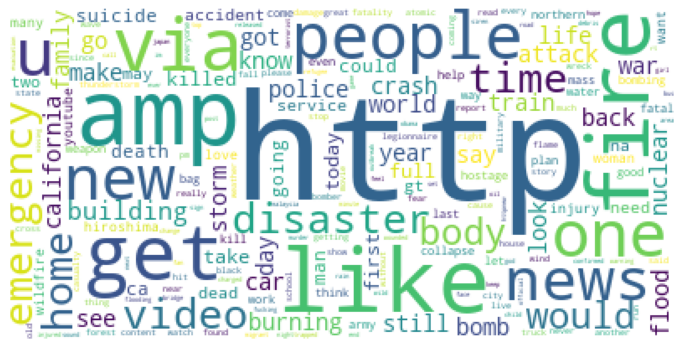

In [55]:
data_viz.word_cloud()

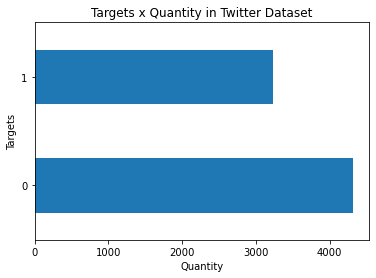

In [73]:
ax = twitter_df['target'].value_counts().plot(kind='barh')
ax = pyplot.title('Targets x Quantity in Twitter Dataset')
ax = pyplot.xlabel('Quantity')
ax = pyplot.ylabel('Targets')

## Clustering

In [81]:
X = twitter_df['clean_text']
y = twitter_df['target']

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 10),
                                    max_df=0.8,
                                    min_df=0.2,
                                    max_features=1000,
                                    norm='l1')

# words by their importance 
tfidf_matrix = tfidf_vectorizer.fit_transform(X) #fit the vectorizer to synopses
idf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())

terms = tfidf_vectorizer.get_feature_names()